In [17]:
execfile('preamble_and_functions.py')

%matplotlib inline

In [3]:
### ------ the width of a time period ------ ###
Delta_t = 0.25

# storage properties
installedCap = 1 # kW
maxDOD = 0.85 # % equivalent full cycle (EFC)
EoL = 0.8 # end of life % equivalent full charge 
maxSOC = np.mean([EoL*installedCap, maxDOD*installedCap])# kWh
minSOC = 0 # kWh
maxChg = 0.5 # kW
maxDisChg = -0.5 # kW
etaChg = 0.948
etaDisChg = 0.948
storageProperties = []
storageProperties.append(maxSOC-minSOC) # kWh
storageProperties.append(maxChg) # kW maxChg
storageProperties.append(maxDisChg) # kW maxDisChg
storageProperties.append(etaChg) # etaChg
storageProperties.append(etaDisChg) # etaDisChg
billingOption = []
# if billingOption[1] == 1 then need a solar export price in billingOption[2], otherwise no
billingChoice = 1
priceExport = 5 # cents/kWh
# choose whether device is allowed to buy and sell back to grid
marketArbitrage = False
billingOption.append(billingChoice) 
billingOption.append(priceExport)
billingOption.append(marketArbitrage)

#### ---------- one price every Delta_t ----####
price = np.ones((96*30))*35 # cents per kWh
print maxSOC

0.825


In [4]:
filename = 'IntermediateData/Workspace96.csv'
WSpace = []
with open(filename) as InFile:
    reader = csv.reader(InFile, delimiter=',')
    for row in reader:
        WSpace.append(row)

In [5]:
generation = np.genfromtxt('IntermediateData/camGenAv.csv', delimiter=',', dtype=None)
print np.shape( generation )
gSum = np.sum( generation, axis=1 )/4
genMax = np.max(generation, axis=1)
genPerWatt = gSum/genMax
print 'Max and min gen per watt ', np.min( genPerWatt ), np.max( genPerWatt )

(4574, 2880)
Max and min gen per watt  79.460226622 131.628462608


In [6]:
print len(WSpace), len(generation)

4574 4574


In [7]:
# arrays for simulating
cambridgeDemand = np.zeros((len(WSpace), len(price)))
parcelCentroids = np.zeros((len(WSpace), 2))
parc_accts = np.zeros((len(WSpace), 1))
clusterIdx = np.zeros((len(WSpace)))

for i in np.arange(len(WSpace)):
    cambridgeDemand[i,:] = WSpace[i][0:len(price)]
    parc_accts[i] = WSpace[i][len(price)+1]
    parcelCentroids[i,:] = WSpace[i][len(price)+2:]
    clusterIdx[i] = WSpace[i][len(price)]
    
cambridgeDemand[cambridgeDemand<0] = 0
totUse = np.sum( cambridgeDemand, axis=1 ) 

# arrays for storing info
user_cost = np.zeros((len(WSpace), 3))
user_DOD = np.zeros((len(WSpace), 1))
userSubType = np.zeros((len(WSpace),1))
userSolarPower = np.zeros((len(WSpace),1))
SolarGen = np.zeros((len(WSpace),1))
userStorage = np.zeros((len(WSpace),1))       

In [8]:
for i in np.arange(len(WSpace)):
    userSolarPower[i] = np.max(generation[i,:])
    SolarGen[i] = np.sum(generation[i, :])
mis = np.zeros((len(WSpace)))
for i, cLoad in enumerate(cambridgeDemand):
    load = cLoad - generation[i,:]
    mis[i] = -np.sum(load[load<0])/SolarGen[i]

misBins = np.arange(0,1.1,0.1)
misHist, mH_edges = np.histogram(mis, misBins, density=False)
misWidths = mH_edges[1:]-mH_edges[:-1]

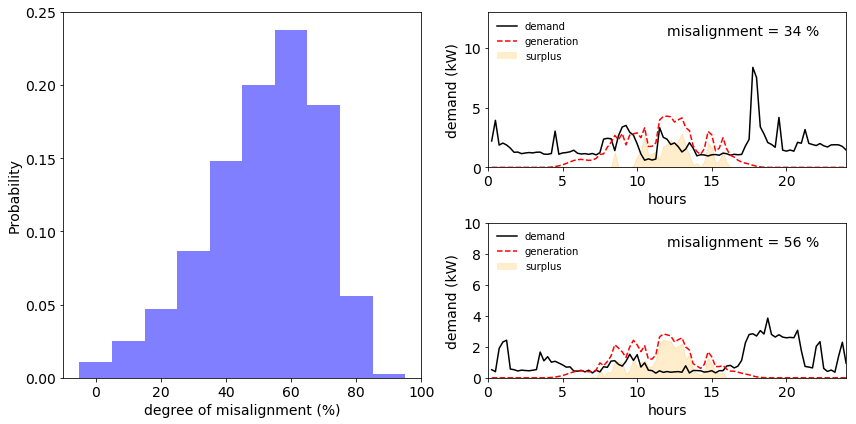

In [10]:
hrs = np.linspace(0.25,24,96)
lw, fs = 1.5, 14
fig1 = plt.figure()
fig1.set_size_inches(12,6)
ax1 = plt.subplot2grid((2,2), (0, 1))
ax2 = plt.subplot2grid((2,2), (1, 1))
ax3 = plt.subplot2grid((2,2), (0,0), rowspan=2)
e1 = 0
l1, = ax1.plot(hrs, cambridgeDemand[e1,0:96], linewidth=lw, color='k')
l2, = ax1.plot(hrs, generation[e1,0:96], linewidth=lw, color='r', linestyle='--')
exports = cambridgeDemand[e1,:]-generation[e1,:]
exports[exports>0] = 0
ax1.fill_between(hrs,0,-exports[0:96],color='orange',alpha=0.2)
mis1 = np.sum(-exports[0:96])/np.sum(generation[e1,0:96])
str111 = 'misalignment = %.0f %%'%(mis1*100) 
ax1.text(0.5,0.85,str111,transform = ax1.transAxes,fontsize=fs)
ax1.set_xlim([0,24]), ax1.set_ylim([0,np.ceil(max(cambridgeDemand[e1,:]))+2]), ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_xlabel('hours',fontsize=fs), ax1.set_ylabel('demand (kW)',fontsize=fs)
r1 = plt.Rectangle((0, 0), 1, 1, fc='orange', alpha=0.2)
ax1.legend([l1,l2,r1], ['demand', 'generation','surplus'], loc=2, frameon=False)


e1 = 12
ax2.plot(hrs, cambridgeDemand[e1,0:96], linewidth=lw, color='k')
ax2.plot(hrs, generation[e1,0:96], linewidth=lw, color='r', linestyle='--')
exports = cambridgeDemand[e1,:]-generation[e1,:]
exports[exports>0] = 0
ax2.fill_between(hrs,0,-exports[0:96],color='orange',alpha=0.2)
mis1 = np.sum(-exports[0:96])/np.sum(generation[e1,0:96])
str111 = 'misalignment = %.0f %%'%(mis1*100) 
ax2.text(0.5,0.85,str111,transform = ax2.transAxes,fontsize=fs)
ax2.set_xlim([0,24]), ax2.set_ylim([0,np.ceil(max(cambridgeDemand[e1,:]))+2])
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xlabel('hours',fontsize=fs), ax2.set_ylabel('demand (kW)',fontsize=fs)
ax2.legend([l1,l2,r1], ['demand', 'generation','surplus'], loc=2, frameon=False)

ax3.bar(misBins[:-1], misHist/4574., width=misWidths, color='blue', alpha=0.5)
ax3.set_xlabel('degree of misalignment (%)',fontsize=fs)
ax3.set_ylabel('Probability',fontsize=fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.set_xticks(np.arange(0,1.1,0.2))
ax3.set_xticklabels(['0','20','40','60','80','100'])

fig1.tight_layout()
#fig1.savefig('Images/IndMis.png', dpi=300, format='png',  bbox_inches='tight')

In [11]:
kcluster = 200
parcCoordDict = { key: value for (key, value) in zip(range(len(parcelCentroids)), parcelCentroids) }

In [12]:
parcCoordDict.items()[0]

(0, array([-71.119761,  42.374445]))

In [13]:
singleHomes = np.arange(len(clusterIdx))
clusterHomes = [singleHomes[a] for a, b in enumerate(clusterIdx) if b==0]

In [14]:
points = parcelCentroids[clusterHomes]-parcelCentroids[0]

In [15]:
clusterHomes[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [18]:
# probabilities of adopting solar
pSolarArray = np.asarray([0.4])
# now load the forty percent example to keep everything the same
FortyPercentSolarExample = np.genfromtxt('IntermediateData/FortyPercentExample.dat', delimiter=',')
# information about microgrids
misMG = np.zeros((kcluster, len(pSolarArray)))
numSolUsers = np.zeros((kcluster,len(pSolarArray)))
totalGen = np.zeros((kcluster,len(pSolarArray)))
numUsers = np.zeros((kcluster))
gList = []

for pSolarNum, pSolar in enumerate(pSolarArray):
    singleHomes = np.arange(len(clusterIdx))
    first_user = 0
    print pSolarNum
    
    sys.stdout.flush()
    
    # for storing the microgrid and individual loads
    MG_dem_no_solar = np.zeros((kcluster,len(price)))
    MG_dem_solar = np.zeros((kcluster,len(price)))
    MG_gen = np.zeros((kcluster,len(price)))
    storageLoads = np.zeros((len(cambridgeDemand),len(price)))
    solarLoads = np.zeros((len(cambridgeDemand),len(price)))
    SolarGen2 = np.zeros((len(cambridgeDemand)))
    
    userTrans = np.zeros((len(cambridgeDemand)))

    for clstr in range(kcluster):
        clusterHomes = [singleHomes[a] for a, b in enumerate(clusterIdx) if b==clstr]
        numUsers[clstr] = len(clusterHomes)
    
        if len(clusterHomes) > 1:
            points = parcelCentroids[clusterHomes]-parcelCentroids[0]
            # make a minum spanning tree between each microgrid node
            G = makeTree(points, clusterHomes, parcCoordDict)

            # choose generator and storage nodes
            genNodes = np.zeros((len(G), 2))
            storageNodes = np.zeros((len(G),2))
            for i in range(len(clusterHomes)):
                r1 = random.uniform(0.0, 1.0)
                if r1 < pSolar:
                    genNodes[i, 0] = 1 # this isn't used - not picking randomly at the mo.
                genNodes[i,0] = FortyPercentSolarExample[first_user+i]
                
            numSolUsers[clstr, pSolarNum] = np.sum(genNodes[:,0])
            
            # consider when each generation node also has storage
            storageNodes[:,0] = genNodes[:,0]
            #storageNodes[storageNodes[:,0]==1,1] = 0

            groupAccts = [parc_accts[node][0] for node in G.nodes()]
            # EE convention, loads are -ve
            groupLoads = -( cambridgeDemand[np.where(parc_accts==groupAccts)[0],:] )
            
            userTrans[first_user:first_user+len(G)] = np.where(parc_accts==groupAccts)[0]            
            
            # PCC has value to balance loads in MG (Kirchoffs law)
            PCCnogen = -(np.sum(groupLoads, axis=0))

            totGen = 0
            for i in range(len(groupAccts)):
                genNodes[i, 1] = userTrans[first_user+i]
                # add in the solar loads, EE convention generation is +ve
                groupLoads[i,:] = groupLoads[i,:] + genNodes[i, 0] * (generation[np.int(genNodes[i, 1]), :])
                
                if genNodes[i,0] == 1:
                    SolarGen2[first_user+i] = np.sum( generation[np.int(genNodes[i, 1]), :] )
                    totGen = totGen + np.sum( generation[np.int(genNodes[i, 1]), :] )
                    userSubType[first_user+i] = 1
                    #if storageNodes[i,0]==1:
                    #    userStorage[first_user+i] = storageNodes[i,1]
                    # calculate the cost using the export tariff
                    MG_gen[clstr,:]=MG_gen[clstr,:]+generation[np.int(genNodes[i, 1]), :]
                
                solarLoads[first_user+i,:] = groupLoads[i,:]
            
            if totGen<1:
                print 'clstr', clstr, 'has no solar'
                
            totalGen[clstr, pSolarNum] = totGen
            PCC = -(np.sum(groupLoads, axis=0))
            first_user = first_user + len(clusterHomes)
            MG_dem_no_solar[clstr,:]=PCCnogen
            MG_dem_solar[clstr,:]=PCC
            
            # make a list containing all the MG networks
            if pSolarNum == 0:
                gList.append( G )
    # finally calculate the misalignment on an MG level
    for i, load in enumerate(MG_dem_solar):
        if totalGen[i, pSolarNum]>0:
            misMG[i, pSolarNum] = -np.sum(load[load<0])/totalGen[i, pSolarNum]

print 'There are ', len( np.where(SolarGen2>0)[0] ), 'solar users'
FortyPercentSolarExample = (SolarGen2>0)+0
print FortyPercentSolarExample[0:10]
#np.savetxt('IntermediateData/FortyPercentExample.dat', FortyPercentSolarExample, delimiter=',')

0
There are  1797 solar users
[1 1 0 0 0 0 1 0 0 0]


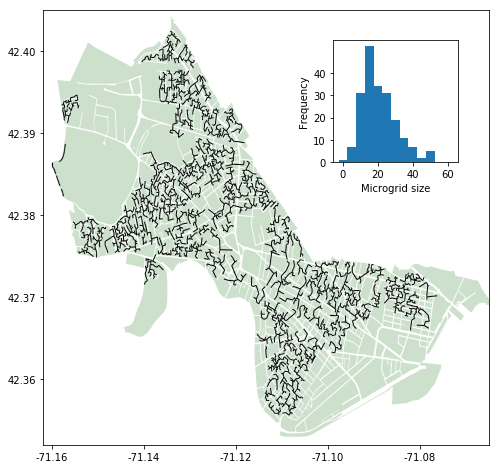

In [22]:
filePath = './InputData/CambParcelsLatLong.shp'
sf = shp.Reader(filePath)
recs = sf.records()
fields = sf.fields
shapes = sf.shapes()
ptchs=[]

fig1 = plt.figure()
fig1.set_size_inches(8,8)
ax1 = fig1.add_subplot(111)
for areas in shapes:
    x=[area[0] for area in areas.points]
    y=[area[1] for area in areas.points]
    #ax.plot(x,y,color='k')
    pols = zip(x,y)
    poly = Polygon(pols)
    ptchs.append(poly)
ax1.add_collection(PatchCollection(ptchs,facecolor='darkgreen', alpha=0.2, edgecolor='none'))
plt.sca(ax1)
for G in gList:
    # draw the edges on the graph
    D1 = nx.draw_networkx_edges(G, parcCoordDict)
ax1.set_xlim([-71.162, -71.065])
ax1.set_ylim([42.352, 42.405])
ax1.set_xticks(np.arange(-71.16,-71.07,0.02))
tickX = []
for entry in np.arange(-71.16,-71.07,0.02):
    tickX.append( '%.2f'%entry )
ax1.set_xticklabels(tickX)
ax1.set_yticks(np.arange(42.36,42.41,0.01))
tickY = []
for entry in np.arange(42.36,42.41,0.01):
    tickY.append( '%.2f'%entry )
ax1.set_yticklabels(tickY)
pos = ax1.get_position()
a = plt.axes([pos.x0 + 0.65*pos.width, pos.y0 + 0.65*pos.height,  pos.width*0.28, pos.height*0.28])
# create a histogram of the microgrid sizes
bW = 5
nUBins = np.arange(0,70,bW)
nUHist, nUEdges = np.histogram(numUsers, nUBins, density=False)
a.bar(nUBins[:-1], nUHist, width=bW)
a.set_xticks(np.arange(0,75,20))
a.set_yticks(np.arange(0,50,10))
a.set_xlabel('Microgrid size')
a.set_ylabel('Frequency')
#fig1.savefig('Images/IllMGs.png', dpi=300, format='png',  bbox_inches='tight')

[ 0.77162378 -0.16151863]
[[ 0.00254004 -0.00099985]
 [-0.00099985  0.00041912]]


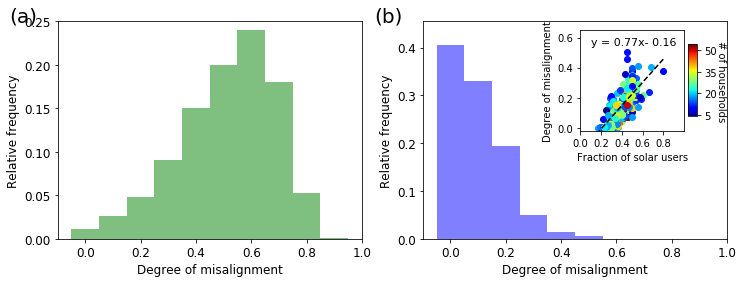

In [23]:
#plot the microgrid misalignments
cm3 = plt.cm.get_cmap('jet')
cNorm3 = colors.Normalize(vmin=min(numUsers), vmax=max(numUsers))
scalarMap3 = cmx.ScalarMappable(norm=cNorm3, cmap=cm3)
scalarMap3._A = []
# redder is more users

fig = plt.figure()
fig.set_size_inches(12,4)
ax1 = fig.add_subplot(122)

misBins = np.arange(0,1.1,0.1)
misHist, mH_edges = np.histogram(misMG, misBins, density=False)
fs = 12
misWidths = mH_edges[1:]-mH_edges[:-1]
ax1.bar(misBins[:-1], misHist/200., width=misWidths, color='b', alpha=0.5)
ax1.set_xlabel('Degree of misalignment',fontsize=fs)
ax1.set_ylabel('Relative frequency',fontsize=fs)
ax1.set_ylim([0, max(misHist/float(sum(misHist)))+0.05])
ax1.tick_params(axis='both', which='major', labelsize=fs)
#ax1.set_title('Microgrid misalignments', y=1.05, fontsize=fs)

b = plt.axes([0.3+0.43, .5, .12, .35])

fracSol = np.zeros(np.shape(numUsers))
for i in range(len(pSolarArray)):
    #print i
    for j in range(kcluster):
        cl = scalarMap3.to_rgba(numUsers[j])
        b.scatter(numSolUsers[j,i]/numUsers[j], misMG[j,i], color=colors.rgb2hex(cl))
        b.set_xlim([0,1]), b.set_ylim([-0.02,0.65])
        b.set_xticks(np.arange(0,1,0.2))
        b.set_ylabel('Degree of misalignment')
        b.set_xlabel('Fraction of solar users')
        fracSol[j] = numSolUsers[j,i]/numUsers[j]

from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
xdata = fracSol
y = func(xdata, 0.8, -0.2)
ydata = np.copy(misMG[:, 0])
popt, pcov = curve_fit(func, xdata, ydata)
print popt
print pcov
# now inspect the curve fit
xdata = np.linspace(0,max(fracSol),30)
ydata = func(xdata, popt[0], popt[1])
b.plot(xdata, ydata, linewidth=1.5, linestyle='--', color='k')
str111 = 'y = %.2fx'%popt[0] + '- %.2f'%(-popt[1])
b.text(0.1,0.85,str111,transform = b.transAxes,fontsize=fs-1)
ax1.text(-0.16,1,'(b)',transform = ax1.transAxes,fontsize=20)

cbar_ax = plt.axes([0.425+0.43, 0.55, 0.01, 0.25])
cbar = fig1.colorbar(scalarMap3, cax=cbar_ax, ticks=[5,20,35,50], orientation='vertical')
cbar_ax.tick_params(axis='both', which='major', labelsize=fs-2)
cbar.set_label('# of households', labelpad=9, rotation=270)
    
# compare this with the misalignments of the individual users
mis = np.zeros((len(np.where(SolarGen2>0)[0])))
for i, j in enumerate(np.where(SolarGen2>0)[0]):
    load = -solarLoads[j,:]
    mis[i] = -np.sum(load[load<0])/SolarGen2[j]
misBins = np.arange(0,1.1,0.1)
misHist, mH_edges = np.histogram(mis, misBins, density=False)
misWidths = mH_edges[1:]-mH_edges[:-1]
ax1 = fig.add_subplot(121)
ax1.bar(misBins[:-1], misHist/float(np.sum(misHist)), width=misWidths, color='g', alpha=0.5)
ax1.set_xlabel('Degree of misalignment',fontsize=fs)
ax1.set_ylabel('Relative frequency',fontsize=fs)
ax1.set_ylim([0, max(misHist/float(sum(misHist)))+0.01])
ax1.tick_params(axis='both', which='major', labelsize=fs)
#ax1.set_title('Indiviual misalignments', y=1.05, fontsize=fs)
ax1.text(-0.16,1,'(a)',transform = ax1.transAxes,fontsize=20)

#fig.savefig('Images/MGmisIndmis.png', dpi=300, format='png',  bbox_inches='tight')

In [24]:
print 'The smallest microgrid has', min( numUsers ), 'users'
print 'The smallest solar fraction is %.2f'%(min(fracSol))
print 'The biggest solar fraction is %.2f'%(max(fracSol))

The smallest microgrid has 4.0 users
The smallest solar fraction is 0.17
The biggest solar fraction is 0.80


microgrid has  19 users


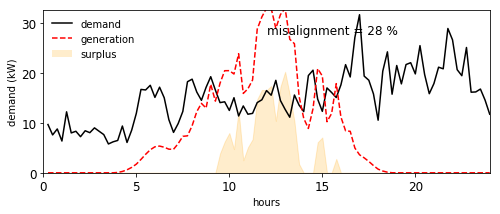

In [25]:
# look at the profiles for a specific microgrid out of interest
fig1 = plt.figure()
fig1.set_size_inches(8,3)
ax1 = fig1.add_subplot(111)
e1 = 2
l1, = ax1.plot(hrs, MG_dem_no_solar[e1,0:96], linewidth=lw, color='k')
l2, = ax1.plot(hrs, MG_gen[e1,0:96], linewidth=lw, color='r', linestyle='--')
exports = MG_dem_no_solar[e1,0:96]-MG_gen[e1,0:96]
exports[exports>0] = 0
ax1.fill_between(hrs,0,-exports[:],color='orange',alpha=0.2)
mis1 = np.sum(-exports[:])/np.sum(MG_gen[e1,0:96])
str111 = 'misalignment = %.0f %%'%(mis1*100) 
ax1.text(0.5,0.85,str111,transform = ax1.transAxes,fontsize=fs)
ax1.set_xlim([0,24])
ax1.set_ylim([0,np.max(MG_dem_no_solar[e1,0:96])+1])
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_xlabel('hours'), ax1.set_ylabel('demand (kW)')
r1 = plt.Rectangle((0, 0), 1, 1, fc='orange', alpha=0.2)
ax1.legend([l1,l2,r1], ['demand', 'generation','surplus'], loc=2, frameon=False)
# Now estimate the point at which 1 kW of storage becomes a profitable investment for each microgrid
numUsers = numUsers.astype(int)
print 'microgrid has ', numUsers[e1], 'users'

In [26]:
cycles = 3000
maxLi = 40
# demonstrate the storage benefit, AOTC and total benefit for one microgrid
r = 0.05 #interest rate

# Model from david Parra tweaked to match powerwall 2
def cost_Storage(noUnits):
    RF = 0
    LiIon_cellCost=250#*(1-RF)
    LiIon_Disrate=0.5
    Inverter_cost_3kW=1500#*(1-RF)
    #BoP_cost_10kW=100*(1-RF)
    Maintenance_cost_10kW=100

    f=0.7
    fp=0.6
    # cell cost
    LiIon_cell_cost=LiIon_cellCost*noUnits
    # absolute inverter cost
    LiIon_Inverter_cap=noUnits*LiIon_Disrate
    Inverter_cost_LiIon=Inverter_cost_3kW*(LiIon_Inverter_cap/3.)**f
    # Absolute BoP cost
    #BoP_cost_LiIon=BoP_cost_10kW*(LiIon_Inverter_cap/10.)**fp
    # Absolute Maintenance cost
    Maintenance_cost_LiIon=Maintenance_cost_10kW*(LiIon_Inverter_cap/10.)**fp
    
    SC = Inverter_cost_LiIon + LiIon_cell_cost
    MC = Maintenance_cost_LiIon# + BoP_cost_LiIon
    return SC, MC

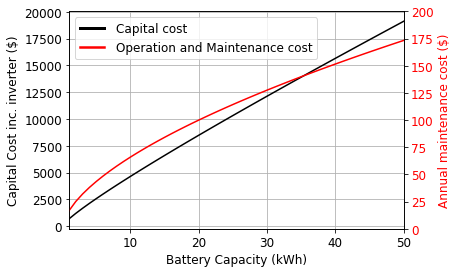

In [27]:
testCaps = np.arange(0,51,1)
testCaps[0] = 1
testCostFn = np.zeros((np.shape(testCaps)))
testMC = np.zeros((np.shape(testCaps)))
#Li = 10
for i, e in enumerate(testCaps):
    storageCost, MC = cost_Storage(e)
    testCostFn[i] = storageCost
    #A_tr = (1-(1/(1+r)**Li))/r
    #AOTC = (storageCost/A_tr + MC)
    #testAOTC[i] = AOTC
    testMC[i] = MC
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(testCaps, testCostFn, color='k')
ax1.set_xlabel('Battery Capacity (kWh)', fontsize=fs)
ax1.set_ylabel('Capital Cost inc. inverter ($)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax2 = ax1.twinx()
ax2.plot(testCaps, testMC, color='red')
ax2.set_ylabel('Annual maintenance cost ($)', color='red', fontsize=fs)
ax2.set_ylim([0, 200])
for tl in ax2.get_yticklabels():
    tl.set_color('red')
ax2.tick_params(axis='both', labelsize=fs)
ax1.set_xlim([1,50])
ax1.grid(True)

import matplotlib.lines as mlines
kL = mlines.Line2D([], [], color='k', linewidth=3, label='Capital cost')
rL = mlines.Line2D([], [], color='r', linewidth=2.5, label='Operation and Maintenance cost')
ax1.legend(handles=[kL, rL], fontsize=fs, handletextpad=1, loc='upper left')

#fig.savefig('Images/CostsCapandMC.png', dpi=300, format='png',  bbox_inches='tight')

In [28]:
# check what the cost of a battery with equal capacity to powerwall is
cost_Storage(14)

(6214.407263449128, 80.73443754472972)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


optimum storage size  83.0 kWh


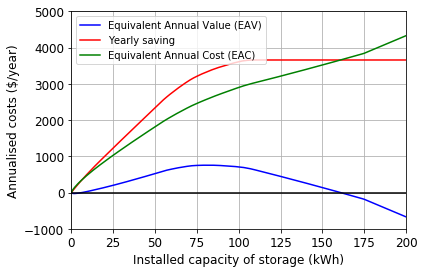

In [29]:
# find the optimum storage capacity for 1 microgrid
noUnits = 0 # initially consider that there is no storage and increment
first_user = 0
stArray = np.linspace(0,200,201)
results = np.zeros((len(stArray),4))

clstr = e1
if clstr == 0:
    groupLoads = solarLoads[0:numUsers[0]]
    #-ve is loads, +ve is generation
    PCC = np.sum(groupLoads, axis=0)
else:
    start = np.sum(numUsers[0:clstr])
    groupLoads = solarLoads[start:start+numUsers[clstr],:]
    PCC = np.sum( groupLoads, axis=0 )

counter=0
while counter<len(stArray):
    noUnits = stArray[counter]
    
    # add in the storage module
    alteredPCC=np.copy( PCC )
    alteredPrice = np.copy( price )

    newDemand, oldCost, newCost, SOC= \
    cycleCharging(noUnits, storageProperties, alteredPCC, alteredPrice, billingOption, Delta_t)  
    
    # now count the cycles in SOC, cycle_counter returns the total SOC over the period, divide by installed Cap to get cycles
    DOD = cycle_counter(SOC)/(installedCap*noUnits) # DOD is the number of Equivalent Full Cycles over a month
    
    if np.isnan(DOD):
        DOD = 1
    if DOD <= 1:
        DOD = 1
    Li = cycles/(DOD*12) # multiply by 12 to get annualised, cycles is the cycles till EOL
    if Li >= maxLi: # cycles is specified above the storage costing function - typically for Liion 1000-4000
        Li = maxLi

    alteredPCC = -newDemand 
    storageCost, MC = cost_Storage(noUnits)
    # now caluclate the total benefit of storage
    A_tr = (1-(1/(1+r)**Li))/r
    AOTC = (storageCost/A_tr + MC)/12
    stB = (oldCost - newCost)/100
    #IRR, NPV = calculate_IRR(storageCost, stB*12, Li, MC, 0, 0, r)

    results[counter,0] = (stB - AOTC)*12
    results[counter,1] = stB*12
    results[counter,2] = AOTC*12
    #results[counter,3] = NPV/A_tr
    counter=counter+1

fs = 12
fig = plt.figure()
ax1 = fig.add_subplot(111)
l1, = ax1.plot(stArray, results[:,0], color='b', linewidth=1.5)#',marker='.')
l2, = ax1.plot(stArray, results[:,1], color='r', linewidth=1.5)#,marker='.')
l3, = ax1.plot(stArray, results[:,2], color='g', linewidth=1.5)#,marker='.')
ax1.legend([l1,l2,l3],['Equivalent Annual Value (EAV)',\
                       'Yearly saving','Equivalent Annual Cost (EAC)'],loc=2)
ax1.plot([-1,np.max(stArray)+1],[0,0],color='k')
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_xlabel('Installed capacity of storage (kWh)',fontsize=fs)
ax1.set_ylabel('Annualised costs ($/year)',fontsize=fs)
ax1.set_xlim([0,np.max(stArray)])
ax1.set_ylim([-1000,5000])
ax1.grid(True)


#fig.savefig('Images/MGESOptExample.png', dpi=300, format='png',  bbox_inches='tight')
print 'optimum storage size ', stArray[np.where(results[:,0]==np.max(results[:,0]))[0]][0], 'kWh'
noMGUnits = stArray[np.where(results[:,0]==np.max(results[:,0]))[0]][0]

In [30]:
# take a closer look at cluster 28
x = np.shape(groupLoads)[0]
# find the optimum storage for each groupLoad
test_benefit = np.zeros((x))
test_stReq = np.zeros((x))
TU_B = np.zeros((x))
userLi = np.zeros((x))
for usr in range(x):
    noUnits = 0 # initially consider that there is no storage and increment
    load = groupLoads[usr]
    testVal = 0
    # count while testVal is greater than zero or noUnits is less than 30
    while (testVal>=0 or noUnits<30):
        noUnits = noUnits + 1
        # add in the storage module
        alteredLoad=np.copy( load )
        alteredPrice = np.copy( price )#

        newDemand, oldCost, newCost, SOC= \
        cycleCharging(noUnits, storageProperties, alteredLoad, alteredPrice, billingOption, Delta_t)    #
        
        # now count the cycles in SOC
        DOD = cycle_counter(SOC)/(installedCap*noUnits)

        if np.isnan(DOD):
            DOD = 1
        if DOD <= 1:
            DOD = 1
        Li = cycles/(DOD*12)
        if Li >= maxLi:
            Li = maxLi            

        # now caluclate the total benefit of storage
        A_tr = (1-(1/(1+r)**Li))/r
        storageCost, MC = cost_Storage(noUnits)
        AOTC = (storageCost/A_tr + MC)/12
        stB = (oldCost - newCost)/100
        testVal = stB - AOTC
        #print 'no. Units', noUnits, 'and tot. b = ', testVal
        if testVal > test_benefit[usr]:
            test_benefit[usr] = stB - AOTC
            TU_B[usr] = stB
            test_stReq[usr] = noUnits
            userLi[usr] = Li
print 'Storage Req.', test_stReq 
print 'Eq. annual annuity', test_benefit*12
print 'Lifetimes', userLi
print 'Annual Benefit per benefit per unit storage', 12*np.sum( test_benefit )/np.sum( test_stReq )

IRR_test = np.zeros((x))

i_if = 0.02 # income inflation
c_if = 0.02 # costs inflation
# r is the discount rate already used
for usr in range(x):
    if test_stReq[usr] > 0:        
        Capex, OM = cost_Storage(test_stReq[usr])
        IRR_test[usr], NPV = calculate_IRR(Capex, (TU_B[usr]*12), userLi[usr], OM, i_if, c_if, r)
    else:
        IRR_test[usr]=np.nan
print 'IRRs', IRR_test*100 

newDemand, oldCost, newCost, SOC= \
cycleCharging(noMGUnits, storageProperties, PCC, alteredPrice, billingOption, Delta_t)

alteredPCC = -newDemand

# now count the cycles in SOC
DOD = cycle_counter(SOC)/(installedCap*noMGUnits)

if np.isnan(DOD):
    DOD = 1
if DOD <= 1:
    DOD = 1
Li = cycles/(DOD*12)
if Li >= maxLi:
    Li = maxLi

# now caluclate the total benefit of storage
A_tr = (1-(1/(1+r)**Li))/r
storageCost, MC = cost_Storage(noMGUnits)
AOTC = (storageCost/A_tr + MC)/12
stB = (oldCost - newCost)/100

#print 'Annual storage Benefit', stB*12
#print 'AOTC', AOTC*12
print 'Storage Required', noMGUnits
print 'lifetime', Li
print 'Eq. annual annuity', (stB - AOTC)*12
print 'Annual benefit per unit', (stB - AOTC)*12/noMGUnits

IRR, NPV = calculate_IRR(storageCost, (stB*12), Li, MC, i_if, c_if, r)

print 'IRR', IRR*100


Storage Req. [ 10.   5.   6.   0.   0.  17.  10.   0.  13.   0.   0.   0.   8.  12.   0.
   0.   0.   0.  11.]
Eq. annual annuity [ 13.22930074  19.32254066   2.23453459   0.           0.          27.39972588
   1.74200108   0.          55.24832967   0.           0.           0.
  21.80879393  26.71672234   0.           0.           0.           0.
  24.69417019]
Lifetimes [ 17.09447386  11.65371638  14.48227405   0.           0.          20.16301056
  18.00279965   0.          16.50941558   0.           0.           0.
  14.81369679  17.52150169   0.           0.           0.           0.
  16.99051887]
Annual Benefit per benefit per unit storage 2.09126216382
IRRs [ 7.53273311  8.26667054  7.20544542         nan         nan  7.6489237
  7.15711942         nan  8.52131766         nan         nan         nan
  7.96575668  7.83507379         nan         nan         nan         nan
  7.83404588]
Storage Required 83.0
lifetime 20.618293589
Eq. annual annuity 755.855740305
Annual benefit p

In [31]:
week = np.arange(0.25, 4*168.01,0.25)

AOTC =  217.851980211
Storage benefit =  280.83995857
83.0


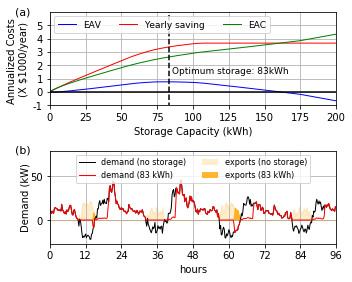

In [32]:
print 'AOTC = ', AOTC
print 'Storage benefit = ', stB

fs = 10
fig = plt.figure()
fig.set_size_inches(5, 4)
ax1 = fig.add_subplot(211)
l1, = ax1.plot(stArray, results[:,0], color='b', linewidth=1)#',marker='.')
l2, = ax1.plot(stArray, results[:,1], color='r', linewidth=1)#,marker='.')
l3, = ax1.plot(stArray, results[:,2], color='g', linewidth=1)#,marker='.')
ax1.legend([l1,l2,l3],['EAV',\
                       'Yearly saving','EAC'],loc=2, fontsize=fs-1,ncol=3)
ax1.plot([-1,np.max(stArray)+1],[0,0],color='k')
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_xlabel('Storage Capacity (kWh)',fontsize=fs)
ax1.set_ylabel('Annualized Costs \n(X $1000/year)',fontsize=fs)
ax1.set_xlim([0,np.max(stArray)])
ax1.set_ylim([-1000,6000])
ax1.set_yticks(np.arange(-1000,5001,1000))
ax1.set_yticklabels(['-1','0','1','2','3','4','5','6'])
ax1.set_xticks(np.arange(0,201,25))
print stArray[np.where(results[:,0]==np.max(results[:,0]))[0]][0]
noMGUnits = stArray[np.where(results[:,0]==np.max(results[:,0]))[0]][0]
ax1.plot([noMGUnits, noMGUnits], [-1200,6200], linestyle='--', color='k')
ax1.grid(True)
ax1.text(-0.12,0.97,'(a)',transform = ax1.transAxes,fontsize=11)
str69 = 'Optimum storage: %.0f'%noMGUnits+'kWh'
ax1.text(85,1400,str69,fontsize=fs-1)

ax1 = fig.add_subplot(212)
ax1.grid(True)
l1, = ax1.plot(week[7*96:11*96], -PCC[7*96:11*96], linewidth=1, color='k')
l2, = ax1.plot(week[7*96:11*96], -alteredPCC[7*96:11*96], linewidth=1, color='r')#, linestyle='--')
exports1 = np.zeros(np.shape(PCC))
exports2 = np.zeros(np.shape(PCC))
exports1[PCC>0] = PCC[PCC>0]
exports2[alteredPCC>0] = alteredPCC[alteredPCC>0]
ax1.fill_between(week[7*96:11*96],0,exports1[7*96:11*96],color='orange',alpha=0.2)
ax1.fill_between(week[7*96:11*96],0,exports2[7*96:11*96],color='orange',alpha=0.8)
#ax1.set_xlim([0,24]) 
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_xlabel('hours', fontsize=fs), ax1.set_ylabel('Demand (kW)', fontsize=fs, labelpad=0)
r1 = plt.Rectangle((0, 0), 1, 1, fc='orange', alpha=0.2)
r2 = plt.Rectangle((0, 0), 1, 1, fc='orange', alpha=0.8)
ax1.legend([l1,l2,r1,r2], ['demand (no storage)', 'demand (%.0f kWh)'%noMGUnits,'exports (no storage)', \
    'exports (%.0f kWh)'%noMGUnits], loc='upper center', ncol=2, fontsize=fs-2)#, frameon=False)
ax1.set_ylim([-27,79])
ax1.set_xlim([168, 264])
ax1.set_xticks(np.arange(168,265,12))
tickXlabs = []
for e in np.arange(168,265,12):
    tickXlabs.append('%.0f'%(e-168))
ax1.set_xticklabels(tickXlabs)
ax1.text(-0.12,0.97,'(b)',transform = ax1.transAxes,fontsize=11)

fig.tight_layout()

#fig.savefig('Images/MGESOptExample.png', dpi=300, format='png',  bbox_inches='tight')

In [ ]:
# # calculate the economically optimum storage for all MGs
# first_user = 0
# MG_cost = np.zeros((kcluster, 4))
# MG_benefit = np.zeros((kcluster))
# MG_stReq = np.zeros((kcluster))
# for clstr in range(kcluster):
#     noUnits = 0 # initially consider that there is no storage and increment
#     #clstr = 5
#     if clstr == 0:
#         groupLoads = solarLoads[0:numUsers[0]]
#         #-ve is loads, +ve is generation
#         PCC = np.sum(groupLoads, axis=0)
#     else:
#         start = np.sum(numUsers[0:clstr])
#         groupLoads = solarLoads[start:start+numUsers[clstr],:]
#         PCC = np.sum(groupLoads, axis=0)
           
#     if billingOption[0] == 1:
#         # calculate the cost using the export tariff
#         #for i in range(numUsers[clstr]):
#             # calculate the cost for each of the individual users
#             #cost1 = np.sum(groupLoads[i,np.where(groupLoads[i,:]>0)[0]]) * billingOption[1] * Delta_t
#             #cost2 = -np.sum( groupLoads[i,np.where(groupLoads[i,:]<0)[0]] * price[np.where(groupLoads[i,:]<0)[0]] ) * Delta_t
#             #user_cost[first_user+i,1] = cost2-cost1
#         # calculate the cost at the MG level
#         cost1 = np.sum(PCC[np.where(PCC>0)[0]]) * billingOption[1] * Delta_t
#         cost2 = -np.sum( PCC[np.where(PCC<0)[0]] * price[np.where(PCC<0)[0]] ) * Delta_t
#         MG_cost[clstr,1] = cost2-cost1
#     else:
#         #for i in range(numUsers[clstr]):
#             #cost2 = -np.sum( groupLoads[i,:] * price ) * Delta_t
#             #user_cost[first_user+i] = cost2
#         cost2 = np.sum( PCC * price ) * Delta_t
#         MG_cost[clstr,1] = cost2
#     # make sure that costs are summed
#     MG_benefit[clstr] = 0
#     testVal = 0
#     # now add storage
#     while (testVal>=-30):# or noUnits<200):
#         noUnits = noUnits + 1
#         # add in the storage module
#         alteredPCC=np.copy( PCC )
#         alteredPrice = np.copy( price )#

#         newDemand, oldCost, newCost, SOC= \
#         cycleCharging(noUnits, storageProperties, alteredPCC, alteredPrice, billingOption, Delta_t)    #

#         alteredPCC = -newDemand 
        
#         # now count the cycles in SOC
#         DOD = cycle_counter(SOC)/(installedCap*noUnits)

#         if np.isnan(DOD):
#             DOD = 1
#         if DOD <= 1:
#             DOD = 1
#         Li = cycles/(DOD*12)
#         if Li >= maxLi:
#             Li = maxLi

#         # now caluclate the total benefit of storage
#         storageCost, MC = cost_Storage(noUnits)        
#         A_tr = (1-(1/(1+r)**Li))/r
#         AOTC = (storageCost/A_tr + MC)/12
#         stB = (oldCost - newCost)/100
#         testVal = stB - AOTC
#         if testVal > MG_benefit[clstr]:
#             MG_benefit[clstr] = stB - AOTC
#             MG_stReq[clstr] = noUnits
#             MG_cost[clstr,2] = oldCost
#             MG_cost[clstr,3] = newCost
# # save the storage required for each MG - can calculate with this later                        
# np.savetxt('Results/MG_required_st.csv', MG_stReq, delimiter=',')

In [ ]:
# #Ind_cost = np.zeros((len(coords), 4))
# Ind_benefit = np.zeros((len(WSpace)))
# Ind_stReq = np.zeros((len(WSpace)))
# for usr in range(len(WSpace)):
#     noUnits = 0 # initially consider that there is no storage and increment
#     load = solarLoads[usr]
#     testVal = 0
#     while (testVal>=-30):# or noUnits<30):
#         noUnits = noUnits + 1
#         # add in the storage module
#         alteredLoad=np.copy( load )
#         alteredPrice = np.copy( price )#

#         newDemand, oldCost, newCost, SOC= \
#         cycleCharging(noUnits, storageProperties, alteredLoad, alteredPrice, billingOption, Delta_t)    #

#         alteredLoad = -newDemand #
        
#         # now count the cycles in SOC
#         DOD = cycle_counter(SOC)/(installedCap*noUnits)

#         if np.isnan(DOD):
#             DOD = 1
#         if DOD <= 1:
#             DOD = 1
#         Li = cycles/(DOD*12)
#         if Li >= maxLi:
#             Li = maxLi     

#         # now caluclate the total benefit of storage
#         storageCost, MC = cost_Storage(noUnits)  
#         A_tr = (1-(1/(1+r)**Li))/r
#         AOTC = (storageCost/A_tr + MC)/12
#         stB = (oldCost - newCost)/100
#         testVal = stB - AOTC
#         if testVal > Ind_benefit[usr]:
#             Ind_benefit[usr] = stB - AOTC
#             Ind_stReq[usr] = noUnits
            
# np.savetxt('Results/Ind_required_st.csv', Ind_stReq, delimiter=',')
# # with this we can calculate the cost per user
# # the average cost per user when st individual vs microgrid

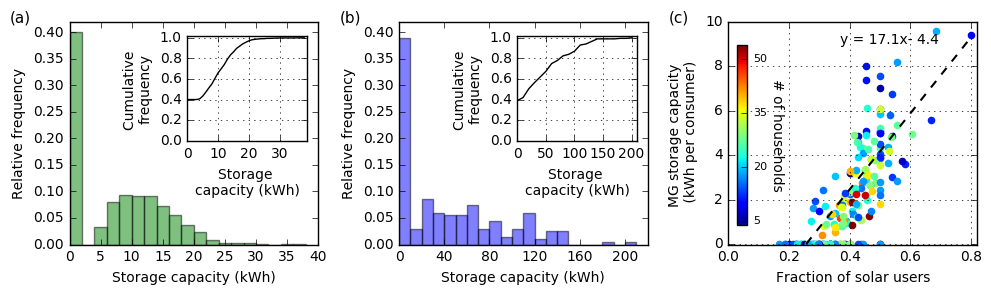

In [103]:
fs = 10

MG_stReq = np.genfromtxt('Results/MG_required_st.csv', delimiter=',')
Ind_stReq = np.genfromtxt('Results/Ind_required_st.csv', delimiter=',')
# plot a distribution of the storage required
stReqBins = np.arange(0,220,10)
stReqHist, stReq_edges = np.histogram(MG_stReq, stReqBins, density=False)
stReqWidths = stReq_edges[1:]-stReq_edges[:-1]
fig = plt.figure()
fig.set_size_inches(10,3)
ax1b = fig.add_subplot(132)
ax1b.bar(stReqBins[:-1], stReqHist/200., width=stReqWidths, color='b', alpha=0.5)
ax1b.set_xlabel('Storage capacity (kWh)',fontsize=fs)
ax1b.set_ylabel('Relative frequency',fontsize=fs)
ax1b.tick_params(axis='both', which='major', labelsize=fs)
ax1b.set_ylim(0,0.42)
ax1b.set_xticks(np.arange(0,220,40))
ax1b.set_xlim([0, 220])

stReqBins = np.arange(0,40,2)
stReqHist, stReq_edges = np.histogram(Ind_stReq[SolarGen2>0], stReqBins, density=False)
stReqWidths = stReq_edges[1:]-stReq_edges[:-1]
ax1a = fig.add_subplot(131)
ax1a.bar(stReqBins[:-1], stReqHist/float(len(np.where(SolarGen2>0)[0])), width=stReqWidths, color='g', alpha=0.5)
ax1a.set_xlabel('Storage capacity (kWh)',fontsize=fs)
ax1a.set_ylabel('Relative frequency',fontsize=fs)
#ax1a.set_title('Optimum size for household consumers')
ax1a.tick_params(axis='both', which='major', labelsize=fs)
ax1a.set_ylim([0,0.42])

ax1 = fig.add_subplot(133)
for j in range(kcluster):
    cl = scalarMap3.to_rgba(numUsers[j])
    ax1.scatter(fracSol[j], MG_stReq[j]/numUsers[j], color=colors.rgb2hex(cl))
ax1.set_xlim([0,0.82])
ax1.set_ylim([-0.02,10])
ax1.set_xticks(np.arange(0,1,0.2))
ax1.set_ylabel('MG storage capacity \n (kWh per consumer)', fontsize=fs)
ax1.set_xlabel('Fraction of solar users', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
xdata = fracSol[MG_stReq>0]
y = func(xdata, 15, -4)
ydata = np.divide(MG_stReq[MG_stReq>0],numUsers[MG_stReq>0])
popt, pcov = curve_fit(func, xdata, ydata)
# now inspect the curve fit
xdata = np.linspace(0,max(fracSol),30)
ydata = func(xdata, popt[0], popt[1])
ax1.plot(xdata, ydata, linewidth=1.5, linestyle='--', color='k')
str111 = 'y = %.1fx'%popt[0] + '- %.1f'%(-popt[1])
ax1.text(0.45,0.9,str111,transform = ax1.transAxes,fontsize=fs)
ax1.grid(True)

fig.tight_layout()

cbar_ax = plt.axes([0.74, 0.25, 0.01, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=[5,20,35,50], orientation='vertical')
cbar_ax.tick_params(axis='both', which='major', labelsize=fs-2)
cbar.set_label('# of households', labelpad=12, rotation=270, fontsize=fs)

plt.sca(ax1b)
stReqBins = np.arange(0,220,10)
stReqHist, stReq_edges = np.histogram(MG_stReq, stReqBins, density=False)
stReqWidths = stReq_edges[1:]-stReq_edges[:-1]
stReqHist, stReq_edges = np.histogram(MG_stReq, stReqBins, density=False)
b = plt.axes([0.52, .53, .12, .35])
l1, = b.plot(stReq_edges[0:-1], np.cumsum(stReqHist)/float(np.sum(stReqHist)), color='k')
b.set_ylim([0,1.02])
b.set_ylabel('Cumulative \nfrequency')
b.set_xlabel('Storage \ncapacity (kWh)')
b.set_xticks(np.arange(0,210,50))
b.set_xlim([0, 210])
b.grid(True)

stReqBins = np.arange(0,40,1)
stReqHist, stReq_edges = np.histogram(Ind_stReq[SolarGen2>0], stReqBins, density=False)
stReqWidths = stReq_edges[1:]-stReq_edges[:-1]
stReqBins = np.arange(0,40,1)
stReqHist, stReq_edges = np.histogram(Ind_stReq[np.where(SolarGen2>0)[0]], stReqBins, density=False)
plt.sca(ax1a)
b = plt.axes([0.19, .53, .12, .35])
l1, = b.plot(stReq_edges[0:-1], np.cumsum(stReqHist)/float(np.sum(stReqHist)), color='k')
b.set_ylim([0,1.02])
b.set_ylabel('Cumulative \nfrequency')
b.set_xlabel('Storage \ncapacity (kWh)')
b.set_xticks(np.arange(0,39,10))
b.set_xlim([0,39])
b.grid(True)

ax1.text(-0.24,1,'(c)',transform = ax1.transAxes,fontsize=11)
ax1a.text(-0.24,1,'(a)',transform = ax1a.transAxes,fontsize=11)
ax1b.text(-0.24,1,'(b)',transform = ax1b.transAxes,fontsize=11)

#fig.savefig('Images/ESOptAll.png', dpi=300, format='png',  bbox_inches='tight')

In [101]:
print max(MG_stReq)

207.0


In [92]:
print len( np.where(Ind_stReq==0)[0] ), 'individual users dont need storage'
print len( np.where(MG_stReq==0)[0] ), 'Microgrids dont need storage'
print 'Total storage for individuals', np.sum(Ind_stReq), 'kWh'
print 'Total storage for microgrids', np.sum(MG_stReq), 'kWh'
print 'Mean storage size for individuals', np.mean( Ind_stReq[Ind_stReq>1] ), 'kWh'
print '25th percentile', np.percentile( Ind_stReq[Ind_stReq>1], 10 ), \
'75th percentile', np.percentile( Ind_stReq[Ind_stReq>1], 90 )

3497 individual users dont need storage
78 Microgrids dont need storage
Total storage for individuals 12974.0 kWh
Total storage for microgrids 8506.0 kWh
Mean storage size for individuals 12.0464252553 kWh
25th percentile 6.0 75th percentile 18.0


In [93]:
#IRR parameters
i_if = 0.02 # income inflation
c_if = 0.02 # costs inflation
# i_if = 0
# c_if = 0

In [94]:
# consider the case when each user has their optimum storage

Ind_cost = np.zeros((4574, 4))
Ind_IRR = np.zeros((4574))
Ind_benefit = np.zeros((4574))
for usr, load in enumerate(solarLoads):
    
    cost2 = np.sum( cambridgeDemand[userTrans[usr]] * price ) * Delta_t
    Ind_cost[usr,0] = cost2
           
    if billingOption[0] == 1:
        # calculate the cost using the export tariff
        cost1 = np.sum(load[np.where(load>0)[0]]) * billingOption[1] * Delta_t
        cost2 = -np.sum( load[np.where(load<0)[0]] * price[np.where(load<0)[0]] ) * Delta_t
        Ind_cost[usr,1] = cost2-cost1
    else:
        cost2 = np.sum( load * price ) * Delta_t
        Ind_cost[usr,1] = cost2
    
    alteredLoad=np.copy( load )
    alteredPrice = np.copy( price )

    newDemand, oldCost, newCost, SOC= \
    cycleCharging(Ind_stReq[usr], storageProperties, alteredLoad, alteredPrice, billingOption, Delta_t)    

    alteredLoad = -newDemand
    Ind_cost[usr,2] = oldCost
    Ind_cost[usr,3] = newCost
    
    # now count the cycles in SOC
    DOD = cycle_counter(SOC)/(installedCap*Ind_stReq[usr])

    if np.isnan(DOD):
        DOD = 1
    if DOD <= 1:
        DOD = 1
    Li = cycles/(DOD*12)
    if Li >= maxLi:
        Li = maxLi 

    # now caluclate the total benefit of storage
    storageCost, MC = cost_Storage(Ind_stReq[usr])  
    A_tr = (1-(1/(1+r)**Li))/r
    AOTC = (storageCost/A_tr + MC)/12
    stB = (oldCost - newCost)/100
    Ind_benefit[usr] = stB - AOTC
    Ind_IRR[usr], NPV = calculate_IRR(storageCost, (stB*12), Li, MC, i_if, c_if, r)
    
    
    storageLoads[usr,:] = alteredLoad


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [95]:
# consider the case when each MG has their optimum storage
MG_dem_storage = np.zeros((np.shape(MG_dem_solar)))
MG_cost = np.zeros((kcluster, 4))
MG_benefit = np.zeros((kcluster))
MG_IRR = np.zeros((kcluster))
for clstr, negPCC in enumerate(MG_dem_solar):
    
    cost2 = np.sum( MG_dem_no_solar[clstr,:] * price ) * Delta_t
    MG_cost[clstr,0] = cost2
    
    ## now make sure the sign of PCC is correct
    PCC = -negPCC
    
    if billingOption[0] == 1:
        cost1 = np.sum(PCC[np.where(PCC>0)[0]]) * billingOption[1] * Delta_t
        cost2 = -np.sum( PCC[np.where(PCC<0)[0]] * price[np.where(PCC<0)[0]] ) * Delta_t
        MG_cost[clstr,1] = cost2-cost1
    else:
        cost2 = np.sum( PCC * price ) * Delta_t
        MG_cost[clstr,1] = cost2

    alteredPCC=np.copy( PCC )
    alteredPrice = np.copy( price )

    newDemand, oldCost, newCost, SOC= \
    cycleCharging(MG_stReq[clstr], storageProperties, alteredPCC, alteredPrice, billingOption, Delta_t)    

    alteredPCC = -newDemand 
    MG_cost[clstr,2] = oldCost
    MG_cost[clstr,3] = newCost
    
    # now count the cycles in SOC
    DOD = cycle_counter(SOC)/(installedCap*MG_stReq[clstr])

    if np.isnan(DOD):
        DOD = 1
    if DOD <= 1:
        DOD = 1
    Li = cycles/(DOD*12)
    if Li >= maxLi:
        Li = maxLi 

    # now caluclate the total benefit of storage
    storageCost, MC = cost_Storage(MG_stReq[clstr])  
    A_tr = (1-(1/(1+r)**Li))/r
    AOTC = (storageCost/A_tr + MC)/12
    stB = (oldCost - newCost)/100
    MG_benefit[clstr] = stB - AOTC
    MG_IRR[clstr], NPV = calculate_IRR(storageCost, (stB*12), Li, MC, i_if, c_if, r)
    MG_dem_storage[clstr,:] = -alteredPCC


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [96]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ee = 100
# ax1.plot(np.arange(1,97), MG_dem_no_solar[ee,0:96])
# ax1.plot(np.arange(1,97), MG_dem_solar[ee,0:96])
# ax1.plot(np.arange(1,97), MG_dem_storage[ee,0:96])

In [97]:
# solar panel
Li = 30 # years
r = 0.05
PVCost = 4000
MC_PV = 20
A_tr = (1-(1/(1+r)**Li))/r
IndSolBenefit = np.zeros((len(solarLoads)))
LCOE_base = np.zeros((len(solarLoads)))
LCOE_use = np.zeros((len(solarLoads)))
index2 = -1
for j in range(len(solarLoads)):
    solarCap = userSolarPower[int(userTrans[j])]
    AOTC = ((PVCost/A_tr + MC_PV)*solarCap)/12
    oldCost = Ind_cost[j,0]
    newCost = Ind_cost[j,1]
    solB = (oldCost - newCost)/100
    IndSolBenefit[j] = solB - AOTC
    if SolarGen2[j] > 0:
        index2 = index2 + 1
        LCOE_base[j] = AOTC/(SolarGen2[j]*Delta_t)
        LCOE_use[j] = AOTC/((1-mis[index2])*SolarGen2[j]*Delta_t)
    
    
# can look at the difference in investment from the perspective of a company - consider all the distributed devices as a
# combined investment in both cases

max base levelised cost of PV gen (just looking at total gen) 0.29386372721
min levelised cost based on usage ((1-misalignment)*gen) 0.20128316598
There are  540 users who find PV profitable
There are  350 use-based-LCOE < 35cents/kWh


<Container object of 49 artists>

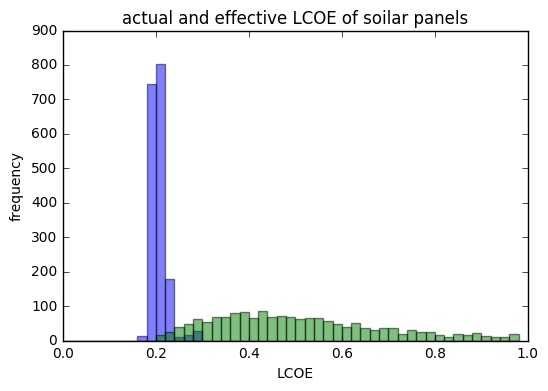

In [98]:
print 'max base levelised cost of PV gen (just looking at total gen)', max(LCOE_base[LCOE_base>0])
print 'min levelised cost based on usage ((1-misalignment)*gen)', min(LCOE_use[LCOE_use>0])
print 'There are ', len(IndSolBenefit[IndSolBenefit>0]), 'users who find PV profitable'
print 'There are ', len(np.where(LCOE_use[LCOE_use>0]<0.35)[0]), 'use-based-LCOE < 35cents/kWh'
LCOEBins = np.arange(0,1,0.02)
LCOEHist, LCOEedges = np.histogram(LCOE_base[LCOE_base>0], LCOEBins, density=False)
LCOEWidths = LCOEedges[1:]-LCOEedges[:-1]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(LCOEBins[:-1], LCOEHist, width=LCOEWidths, color='b', alpha=0.5)
ax1.set_xlabel('LCOE',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.set_title('actual and effective LCOE of solar panels')
ax1.tick_params(axis='both', which='major', labelsize=fs)
LCOEHist, LCOEedges = np.histogram(LCOE_use[LCOE_use>0], LCOEBins, density=False)
ax1.bar(LCOEBins[:-1], LCOEHist, width=LCOEWidths, color='g', alpha=0.5)

In [99]:
MG_dem_ind_storage = np.zeros((np.shape(MG_dem_storage)))
for clstr in range(kcluster):
    if clstr == 0:
        groupLoads = storageLoads[0:numUsers[0]]
        #-ve is loads, +ve is generation
        PCC = np.sum(groupLoads, axis=0)
    else:
        start = np.sum(numUsers[0:clstr])
        groupLoads = storageLoads[start:start+numUsers[clstr],:]
        PCC = np.sum(groupLoads, axis=0)
    MG_dem_ind_storage[clstr,:] = -PCC

In [100]:
# # make a table of results
# print 'Base Consumption = ', np.sum(cambridgeDemand)*Delta_t/1000
# print 'Solar Generation = ', np.sum(SolarGen2)*Delta_t/1000
# print 'Solar Imports = ', np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t/1000
# print 'Solar Exports = ', -np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t/1000
# print 'Average solar saving (ind - all users) = ', np.mean(Ind_cost[:,0]-Ind_cost[:,1])/100
# print 'Average solar saving (ind - solar users) = ',\
# np.mean(Ind_cost[np.where(SolarGen2>0)[0],0]-Ind_cost[np.where(SolarGen2>0)[0],1])/100

# print 'Average solar saving (MG - all users) = ', np.mean(np.divide(MG_cost[:,0]-MG_cost[:,1],numUsers))/100

# print 'total installed storage (ind) = ', np.sum(Ind_stReq)/1000
# print 'total installed storage (MG) = ', np.sum(MG_stReq)/1000

# print 'Average annualised storage benefit per unit (Ind) = ', \
# 12*(np.sum(Ind_benefit)) / ( np.sum(Ind_stReq) )

# print 'Average annualised storage benefit per unit (MG) = ', \
# 12*(np.sum(MG_benefit))/ ( np.sum(MG_stReq) )

# print 'Import red. per unit (Ind)', Delta_t* (np.sum(MG_dem_solar[MG_dem_solar>0]) - \
# np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])) / np.sum(Ind_stReq)

# print 'Import red. per unit (MG)', Delta_t* (np.sum(MG_dem_solar[MG_dem_solar>0]) - \
# np.sum(MG_dem_storage[MG_dem_storage>0])) / np.sum(MG_stReq)

# print 'Export red. per unit (Ind)', Delta_t* (-np.sum(MG_dem_solar[MG_dem_solar<0]) + \
# np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])) / np.sum(Ind_stReq)

# print 'Export red. per unit (MG)', Delta_t* (-np.sum(MG_dem_solar[MG_dem_solar<0]) + \
# np.sum(MG_dem_storage[MG_dem_storage<0])) / np.sum(MG_stReq)

# print 'Total import reduction (MG)', \
# np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t - np.sum(MG_dem_storage[MG_dem_storage>0])*Delta_t
# print 'Total import reduction (ind)', \
# np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t - np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])*Delta_t

# print 'Total export reduction (MG)', \
# np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t - np.sum(MG_dem_storage[MG_dem_storage<0])*Delta_t
# print 'Total export reduction (ind)', \
# np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t - np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])*Delta_t

print 'total energy consumption. IND: ', np.sum(cambridgeDemand)*Delta_t/1000, 'MG:', np.sum(cambridgeDemand)*Delta_t/1000
print 'total solar gen. IND:', np.sum(SolarGen2)*Delta_t/1000, 'MG:', np.sum(SolarGen2)*Delta_t/1000
print 'no storage solar exports. IND:', -np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t/1000, 'MG:', \
-np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t/1000
print 'no storage solar imports. IND:', np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t/1000, 'MG:', \
np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t/1000
print 'total installed storage. IND:', np.sum(Ind_stReq)/1000, 'MG:', np.sum(MG_stReq)/1000
print 'Average IRR IND:', np.nanmean(Ind_IRR)*100, 'MG:', np.nanmean(MG_IRR)*100
print 'Imports with storage. IND:', np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])*Delta_t/1000, \
'MG:', np.sum(MG_dem_storage[MG_dem_storage>0])*Delta_t/1000
print 'Exports with storage. IND:', -np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])*Delta_t/1000, 'MG:', \
-np.sum(MG_dem_storage[MG_dem_storage<0])*Delta_t/1000
print 'Import red. per unit IND:', Delta_t* (np.sum(MG_dem_solar[MG_dem_solar>0]) - \
np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])) / np.sum(Ind_stReq), \
'MG:', Delta_t* (np.sum(MG_dem_solar[MG_dem_solar>0]) - \
np.sum(MG_dem_storage[MG_dem_storage>0])) / np.sum(MG_stReq)
print 'Export red. per unit IND:', Delta_t* (-np.sum(MG_dem_solar[MG_dem_solar<0]) + \
np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])) / np.sum(Ind_stReq), \
'MG:', Delta_t* (-np.sum(MG_dem_solar[MG_dem_solar<0]) + \
np.sum(MG_dem_storage[MG_dem_storage<0])) / np.sum(MG_stReq)

print '\n'

print 'Total import reduction (MG)', \
np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t - np.sum(MG_dem_storage[MG_dem_storage>0])*Delta_t
print 'Total import reduction (ind)', \
np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t - np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])*Delta_t

print 'Total export reduction (MG)', \
np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t - np.sum(MG_dem_storage[MG_dem_storage<0])*Delta_t
print 'Total export reduction (ind)', \
np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t - np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])*Delta_t



total energy consumption. IND:  3244.70893343 MG: 3244.70893343
total solar gen. IND: 850.888953408 MG: 850.888953408
no storage solar exports. IND: 129.531261897 MG: 129.531261897
no storage solar imports. IND: 2523.35124192 MG: 2523.35124192
total installed storage. IND: 12.974 MG: 8.506
Average IRR IND: 8.02503884578 MG: 9.34682481915
Imports with storage. IND: 2463.7730753 MG: 2431.91902892
Exports with storage. IND: 49.5033705048 MG: 27.7934116131
Import red. per unit IND: 4.59212013429 MG: 10.7491433108
Export red. per unit IND: 6.1683283022 MG: 11.9607159986


Total import reduction (MG) 91432.213002
Total import reduction (ind) 59578.1666223
Total export reduction (MG) -101737.850284
Total export reduction (ind) -80027.8913927


In [104]:
# # plot averages
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# for i in range(4):
#     if i == 0:
#         load = np.atleast_2d( np.sum(MG_dem_no_solar, axis=0) )
#     if i == 1:
#         load = np.atleast_2d( np.sum(MG_dem_solar, axis=0) )
#     if i == 2:
#         load = np.atleast_2d( np.sum(MG_dem_ind_storage, axis=0) )
#     if i == 3:
#         load = np.atleast_2d( np.sum(MG_dem_storage, axis=0) )
#     print np.shape(load)
#     load = np.reshape(load, (30,96))
#     #prof = np.average(load, axis=0)
#     prof = load[5,:]
#     if i<3:
#         ax1.plot(np.arange(1,96+1),prof)
#     else:
#         ax1.plot(np.arange(1,96+1),prof,linestyle='--')


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


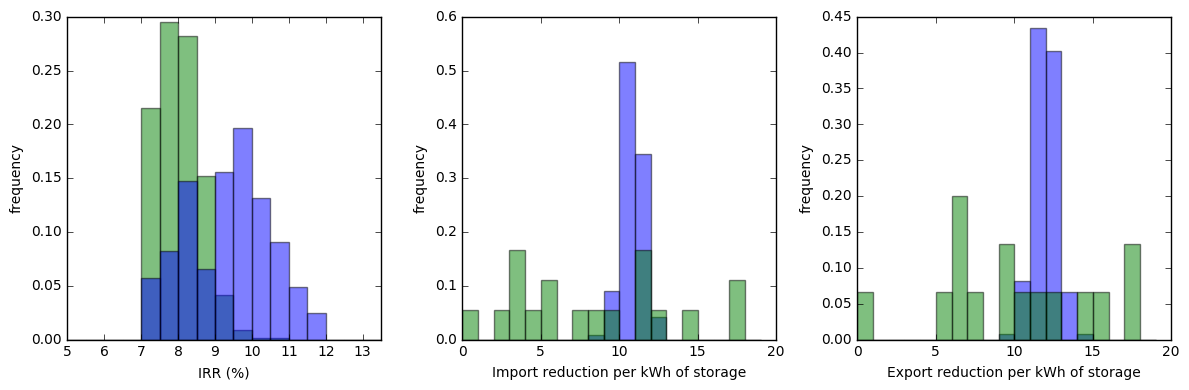

In [105]:
EAB = np.zeros((4574))
for i in range(4574):
    if Ind_stReq[i]>0:
        EAB[i] = 12*Ind_benefit[i]/Ind_stReq[i]
MEAB = np.zeros((kcluster))
for i in range(kcluster):
    if MG_stReq[i]>0:
        MEAB[i] = 12*MG_benefit[i]/MG_stReq[i]

# plot histogram of IRR's
IRR_Bins = np.arange(5,15,0.5)
IRR_Hist, IRR_edges = np.histogram(Ind_IRR[Ind_IRR>0]*100, IRR_Bins, density=False)
IRR_Widths = IRR_edges[1:]-IRR_edges[:-1]
fig = plt.figure()
fig.set_size_inches(12,4)
ax1 = fig.add_subplot(131)
ax1.bar(IRR_Bins[:-1], IRR_Hist/float(np.sum(IRR_Hist)), width=IRR_Widths, color='g', alpha=0.5)
ax1.set_xlabel('IRR (%)',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
MIRR_Hist, IRR_edges = np.histogram(MG_IRR[MG_IRR>0]*100, IRR_Bins, density=False)
ax1.bar(IRR_Bins[:-1], MIRR_Hist/float(np.sum(MIRR_Hist)), width=IRR_Widths, color='b', alpha=0.5)
ax1.set_xlim([5,13.5])

ImportRedMG = np.zeros(kcluster)
ImportRedInd = np.zeros(kcluster)
for i in range(kcluster):
    load1 = MG_dem_solar[i,:]
    load2 = MG_dem_storage[i,:]
    if MG_stReq[i]>0:
        ImportRedMG[i] = Delta_t*( np.sum(load1[load1>0]) - np.sum(load2[load2>0]) ) / MG_stReq[i]
    load3 = MG_dem_ind_storage[i,:]
    if Ind_stReq[i]>0:
        ImportRedInd[i] = Delta_t*( np.sum(load1[load1>0]) - np.sum(load3[load3>0]) ) / Ind_stReq[i]
    
Imp_Bins = np.arange(0.01,20,1)
Imp_Hist, Imp_edges = np.histogram(ImportRedMG, Imp_Bins, density=False)
Imp_Widths = Imp_edges[1:]-Imp_edges[:-1]
ax1 = fig.add_subplot(132)
ax1.bar(Imp_Bins[:-1], Imp_Hist/float(np.sum(Imp_Hist)), width=Imp_Widths, color='b', alpha=0.5)
Imp_Hist, Imp_edges = np.histogram(ImportRedInd, Imp_Bins, density=False)
ax1.bar(Imp_Bins[:-1], Imp_Hist/float(np.sum(Imp_Hist)), width=Imp_Widths, color='g', alpha=0.5)
ax1.set_xlabel('Import reduction per kWh of storage',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

ExportRedMG = np.zeros(kcluster)
ExportRedInd = np.zeros(kcluster)
for i in range(kcluster):
    load1 = MG_dem_solar[i,:]
    load2 = MG_dem_storage[i,:]
    if MG_stReq[i]>0:
        ExportRedMG[i] = -Delta_t*( np.sum(load1[load1<0]) - np.sum(load2[load2<0]) ) / MG_stReq[i]
    load3 = MG_dem_ind_storage[i,:]
    if Ind_stReq[i]>0:
        ExportRedInd[i] = -Delta_t*( np.sum(load1[load1<0]) - np.sum(load3[load3<0]) ) / Ind_stReq[i]
    
Exp_Hist, Imp_edges = np.histogram(ExportRedMG, Imp_Bins, density=False)
ax1 = fig.add_subplot(133)
ax1.bar(Imp_Bins[:-1], Exp_Hist/float(np.sum(Exp_Hist)), width=Imp_Widths, color='b', alpha=0.5)
Exp_Hist, Imp_edges = np.histogram(ExportRedInd, Imp_Bins, density=False)
ax1.bar(Imp_Bins[:-1], Exp_Hist/float(np.sum(Exp_Hist)), width=Imp_Widths, color='g', alpha=0.5)

ax1.set_xlabel('Export reduction per kWh of storage',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


y = 8.2x + 5.7


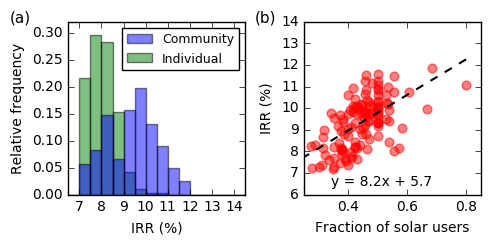

In [107]:
EAB = np.zeros((4574))
for i in range(4574):
    if Ind_stReq[i]>0:
        EAB[i] = 12*Ind_benefit[i]/Ind_stReq[i]
MEAB = np.zeros((kcluster))
for i in range(kcluster):
    if MG_stReq[i]>0:
        MEAB[i] = 12*MG_benefit[i]/MG_stReq[i]

# plot histogram of IRR's
IRR_Bins = np.arange(5,15,0.5)
IRR_Hist, IRR_edges = np.histogram(Ind_IRR[Ind_IRR>0]*100, IRR_Bins, density=False)
IRR_Widths = IRR_edges[1:]-IRR_edges[:-1]

fs = 10
fig = plt.figure()
fig.set_size_inches(5,2.5)
ax1 = fig.add_subplot(121)
ax1.bar(IRR_Bins[:-1], IRR_Hist/float(np.sum(IRR_Hist)), width=IRR_Widths, color='g', alpha=0.5)
ax1.set_xlabel('IRR (%)',fontsize=fs)
ax1.set_ylabel('Relative frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
MIRR_Hist, IRR_edges = np.histogram(MG_IRR[MG_IRR>0]*100, IRR_Bins, density=False)
ax1.bar(IRR_Bins[:-1], MIRR_Hist/float(np.sum(MIRR_Hist)), width=IRR_Widths, color='b', alpha=0.5)
ax1.set_xlim([6.5,14.5])
ax1.set_ylim([0,0.32])
ax1.text(-0.33,1,'(a)',transform = ax1.transAxes,fontsize=11)


r1 = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.5)
ax1.legend([r1,r2], ['Community', 'Individual'], loc=1, fontsize=fs-1)

ax1 = fig.add_subplot(122)
for j in range(kcluster):
    ax1.scatter(fracSol[j], 100*MG_IRR[j], s=40, color='r', alpha=0.5)
ax1.set_xticks(np.arange(0,1,0.2))
ax1.set_ylabel('IRR (%)', fontsize=fs)
ax1.set_xlabel('Fraction of solar users', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

xdata = fracSol[np.isnan(MG_IRR)==False]
y = func(xdata, 15, -4)
ydata = 100*MG_IRR[np.isnan(MG_IRR)==False]
popt, pcov = curve_fit(func, xdata, ydata)
# now inspect the curve fit
xdata = np.linspace(0,max(fracSol),30)
ydata = func(xdata, popt[0], popt[1])
ax1.plot(xdata, ydata, linewidth=1.5, linestyle='--', color='k')
ax1.set_xlim([0.25, 0.85])
ax1.set_ylim([6, 14])
ax1.text(-0.28,1,'(b)',transform = ax1.transAxes,fontsize=11)
str111 = 'y = %.1fx'%popt[0] + ' + %.1f'%(popt[1])
print str111
ax1.text(0.15,0.05,str111,transform = ax1.transAxes,fontsize=10)

fig.tight_layout()
#fig.savefig('Images/IRRs.png', dpi=300, format='png',  bbox_inches='tight')

y = 10.77x + 5.50
